##### Copyright 2021 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/transfer_learning_audio"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/transfer_learning_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/yamnet/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Transfer Learning with YAMNet for environmental sound classification

[YAMNet](https://tfhub.dev/google/yamnet/1) is an audio event classifier that can predict audio events from [521 classes](https://github.com/tensorflow/models/blob/master/research/audioset/yamnet/yamnet_class_map.csv), like laughter, barking, or a siren. 

 In this tutorial you will learn how to:

- Load and use the YAMNet model for inference.
- Build a new model using the YAMNet embeddings to classify cat and dog sounds.
- Evaluate and export your model.


## Import TensorFlow and other libraries


Start by installing [TensorFlow I/O](https://www.tensorflow.org/io), which will make it easier for you to load audio files off disk.

In [2]:
# !pip install -q tensorflow_io

You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_io as tfio

## About YAMNet

YAMNet is an audio event classifier that takes audio waveform as input and makes independent predictions for each of 521 audio events from the [AudioSet](https://research.google.com/audioset/) ontology.

Internally, the model extracts "frames" from the audio signal and processes batches of these frames. This version of the model uses frames that are 0.96s long and extracts one frame every 0.48s.

The model accepts a 1-D float32 Tensor or NumPy array containing a waveform of arbitrary length, represented as mono 16 kHz samples in the range `[-1.0, +1.0]`. This tutorial contains code to help you convert a `.wav` file into the correct format.

The model returns 3 outputs, including the class scores, embeddings (which you will use for transfer learning), and the log mel spectrogram. You can find more details [here](https://tfhub.dev/google/yamnet/1), and this tutorial will walk you through using these in practice.

One specific use of YAMNet is as a high-level feature extractor: the `1024-D` embedding output of YAMNet can be used as the input features of another shallow model which can then be trained on a small amount of data for a particular task. This allows the quick creation of specialized audio classifiers without requiring a lot of labeled data and without having to train a large model end-to-end.

You will use YAMNet's embeddings output for transfer learning and train one or more [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers on top of this.

First, you will try the model and see the results of classifying audio. You will then construct the data pre-processing pipeline.

### Loading YAMNet from TensorFlow Hub

You are going to use YAMNet from [Tensorflow Hub](https://tfhub.dev/) to extract the embeddings from the sound files.

Loading a model from TensorFlow Hub is straightforward: choose the model, copy its URL and use the `load` function.

Note: to read the documentation of the model, you can use the model url in your browser.

In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

With the model loaded and following the [models's basic usage tutorial](https://www.tensorflow.org/hub/tutorials/yamnet) you'll download a sample wav file and run the inference.


In [3]:
testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

221184/215546 [==============================] - 0s 2us/step
./test_data\miaow_16k.wav


You will need a function to load the audio files. They will also be used later when working with the training data.

Note: The returned `wav_data` from `load_wav_16k_mono` is already normalized to values in `[-1.0, 1.0]` (as stated in the model's [documentation](https://tfhub.dev/google/yamnet/1)).

In [4]:
# Util functions for loading audio files and ensure the correct sample rate

@tf.function
def load_wav_16k_mono(filename):
    """ read in a waveform file and convert to 16 kHz mono """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


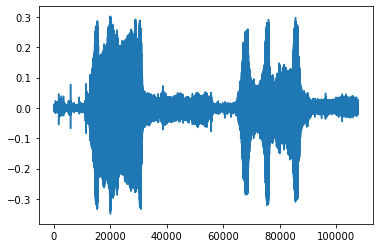

In [5]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data,rate=16000)

In [21]:
file_contents = tf.io.read_file(testing_wav_file_name)

In [16]:
wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_samples=-1,
          desired_channels=-1)
print(sample_rate)
print(wav)

tf.Tensor(16000, shape=(), dtype=int32)
tf.Tensor(
[[-0.00323486]
 [-0.00170898]
 [ 0.00308228]
 ...
 [-0.01098633]
 [-0.0128479 ]
 [-0.01364136]], shape=(107698, 1), dtype=float32)


In [17]:
wav = tf.squeeze(wav, axis=-1)
wav

<tf.Tensor: shape=(107698,), dtype=float32, numpy=
array([-0.00323486, -0.00170898,  0.00308228, ..., -0.01098633,
       -0.0128479 , -0.01364136], dtype=float32)>

In [18]:
sample_rate = tf.cast(sample_rate, dtype=tf.int64)
wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
wav

<tf.Tensor: shape=(107698,), dtype=float32, numpy=
array([-1.8715975e-08,  6.4694795e-08, -1.3643448e-07, ...,
       -1.0721452e-02, -1.1387254e-02, -1.3193554e-02], dtype=float32)>

### Load the class mapping

It's important to load the class names that YAMNet is able to recognize. The mapping file is present at `yamnet_model.class_map_path()`, in the `csv` format.

In [19]:
class_map_path = yamnet_model.class_map_path().numpy().decode('utf-8')
class_names =list(pd.read_csv(class_map_path)['display_name'])

for name in class_names[:20]:
    print(name)
print('...')

Speech
Child speech, kid speaking
Conversation
Narration, monologue
Babbling
Speech synthesizer
Shout
Bellow
Whoop
Yell
Children shouting
Screaming
Whispering
Laughter
Baby laughter
Giggle
Snicker
Belly laugh
Chuckle, chortle
Crying, sobbing
...


### Run inference

YAMNet provides frame-level class-scores (i.e., 521 scores for every frame). In order to determine clip-level predictions, the scores can be aggregated per-class across frames (e.g., using mean or max aggregation). This is done below by `scores_np.mean(axis=0)`. Finally, in order to find the top-scored class at the clip-level, we take the maximum of the 521 aggregated scores.


In [22]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]

print(f'The main sound is: {infered_class}')
print(f'The embeddings shape: {embeddings.shape}')

The main sound is: Animal
The embeddings shape: (13, 1024)


Note: The model correctly inferred an animal sound. Your goal is to increase accuracy for specific classes. Also, notice that the the model generated 13 embeddings, 1 per frame.

## ESC-50 dataset

The [ESC-50 dataset](https://github.com/karolpiczak/ESC-50#repository-content), well described [here](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf), is a labeled collection of 2000 environmental audio recordings (each 5 seconds long). The data consists of 50 classes, with 40 examples per class.

Next, you will download and extract it. 


In [23]:
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

645636096/Unknown - 676s 1us/step

### Explore the data

The metadata for each file is specified in the csv file at `./datasets/ESC-50-master/meta/esc50.csv`

and all the audio files are in `./datasets/ESC-50-master/audio/`

You will create a pandas dataframe with the mapping and use that to have a clearer view of the data.


In [24]:
esc50_csv = './datasets/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


### Filter the data

Given the data on the dataframe, you will apply some transformations:

- filter out rows and use only the selected classes (dog and cat). If you want to use any other classes, this is where you can choose them.
- change the filename to have the full path. This will make loading easier later.
- change targets to be within a specific range. In this example, dog will remain 0, but cat will become 1 instead of its original value of 5.

In [25]:
my_classes = ['dog', 'cat']
map_class_to_id = {'dog':0, 'cat':1}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filtered_pd.head(10)

,filename,fold,target,category,esc10,src_file,take
0,./datasets/ESC-50-master/audio/1-100032-A-0.wav,1,0,dog,True,100032,A
14,./datasets/ESC-50-master/audio/1-110389-A-0.wav,1,0,dog,True,110389,A
157,./datasets/ESC-50-master/audio/1-30226-A-0.wav,1,0,dog,True,30226,A
158,./datasets/ESC-50-master/audio/1-30344-A-0.wav,1,0,dog,True,30344,A
170,./datasets/ESC-50-master/audio/1-32318-A-0.wav,1,0,dog,True,32318,A
175,./datasets/ESC-50-master/audio/1-34094-A-5.wav,1,1,cat,False,34094,A
176,./datasets/ESC-50-master/audio/1-34094-B-5.wav,1,1,cat,False,34094,B
229,./datasets/ESC-50-master/audio/1-47819-A-5.wav,1,1,cat,False,47819,A
230,./datasets/ESC-50-master/audio/1-47819-B-5.wav,1,1,cat,False,47819,B
231,./datasets/ESC-50-master/audio/1-47819-C-5.wav,1,1,cat,False,47819,C


### Load the audio files and retrieve embeddings

Here you'll apply the `load_wav_16k_mono` and prepare the wav data for the model.

When extracting embeddings from the wav data, you get an array of shape `(N, 1024)`  where `N` is the number of frames that YAMNet found (one for every 0.48 seconds of audio).

Your model will use each frame as one input so you need to to create a new column that has one frame per row. You also need to expand the labels and fold column to proper reflect these new rows.

The expanded fold column keeps the original value. You cannot mix frames because, when doing the splits, you might end with parts of the same audio on different splits and that would make our validation and test steps less effective.

In [26]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [30]:
folds.unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [27]:
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [28]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label, fold):
    ''' run YAMNet to extract embedding from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

### Split the data

You will use the `fold` column to split the dataset into train, validation and test.

The fold values are so that files from the same original wav file are keep on the same split, you can find more information on the [paper](https://www.karolpiczak.com/papers/Piczak2015-ESC-Dataset.pdf) describing the dataset.

The last step is to remove the `fold` column from the dataset since we're not going to use it anymore on the training process.


In [31]:
cached_ds = main_ds.cache()
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# remove the folds column now that it's not needed anymore
remove_fold_column = lambda embedding, label, fold: (embedding, label)

train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

## Create your model

You did most of the work!
Next, define a very simple Sequential Model to start with -- one hiden layer and 2 outputs to recognize cats and dogs.


In [32]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 525,826
Trainable params: 525,826
Non-trainable params: 0
_________________________________________________________________


In [33]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [34]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=val_ds,
                       callbacks=callback)

Epoch 1/20
15/15 [==============================] - 6s 74ms/step - loss: 1.3929 - accuracy: 0.8229 - val_loss: 1.3155 - val_accuracy: 0.8813
Epoch 2/20
15/15 [==============================] - 0s 23ms/step - loss: 0.5153 - accuracy: 0.8854 - val_loss: 0.5160 - val_accuracy: 0.8750
Epoch 3/20
15/15 [==============================] - 0s 23ms/step - loss: 0.2660 - accuracy: 0.9000 - val_loss: 0.3451 - val_accuracy: 0.8750
Epoch 4/20
15/15 [==============================] - 0s 23ms/step - loss: 0.2887 - accuracy: 0.9125 - val_loss: 0.6231 - val_accuracy: 0.8750
Epoch 5/20
15/15 [==============================] - 0s 22ms/step - loss: 0.2194 - accuracy: 0.9167 - val_loss: 0.2139 - val_accuracy: 0.8875
Epoch 6/20
15/15 [==============================] - 0s 23ms/step - loss: 0.1662 - accuracy: 0.9104 - val_loss: 0.2190 - val_accuracy: 0.9187
Epoch 7/20
15/15 [==============================] - 0s 29ms/step - loss: 0.2285 - accuracy: 0.9375 - val_loss: 0.2223 - val_accuracy: 0.9187
Epoch 8/20
15

Lets run the evaluate method on the test data just to be sure there's no overfitting.

In [35]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

5/5 [==============================] - 0s 4ms/step - loss: 0.2622 - accuracy: 0.9000
Loss:  0.2622297406196594
Accuracy:  0.8999999761581421


You did it!

## Test your model

Next, try your model on the embedding from the previous test using YAMNet only.


In [36]:
scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

infered_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {infered_class}')

The main sound is: cat


## Save a model that can directly take a wav file as input

Your model works when you give it the embeddings as input.

In a real situation you'll want to give it the sound data directly.

To do that you will combine YAMNet with your model into one single model that you can export for other applications.

To make it easier to use the model's result, the final layer will be a `reduce_mean` operation. When using this model for serving, as you will see bellow, you will need the name of the final layer. If you don't define one, TF will auto define an incremental one that makes it hard to test as it will keep changing everytime you train the model. When using a raw tf operation you can't assign a name to it. To address this issue, you'll create a custom layer that just apply `reduce_mean` and you will call it 'classifier'.


In [37]:
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, input):
        return tf.math.reduce_mean(input, axis=self.axis)

In [38]:
saved_model_path = './dogs_and_cats_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet\assets


INFO:tensorflow:Assets written to: ./dogs_and_cats_yamnet\assets


In [40]:
tf.keras.utils.plot_model(serving_model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Load your saved model to verify that it works as expected.

In [41]:
reloaded_model = tf.saved_model.load(saved_model_path)

And for the final test: given some sound data, does your model return the correct result?

In [43]:
reloaded_results = reloaded_model(testing_wav_data)
cat_or_dog = my_classes[tf.argmax(reloaded_results)]
print(f'The main sound is: {cat_or_dog}')

The main sound is: cat


If you want to try your new model on a serving setup, you can use the 'serving_default' signature.

In [44]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
cat_or_dog = my_classes[tf.argmax(serving_results['classifier'])]
print(f'The main sound is: {cat_or_dog}')


The main sound is: cat


## (Optional) Some more testing

The model is ready.

Let's compare it to YAMNet on the test dataset.

./datasets/ESC-50-master/audio/5-256452-A-5.wav


Waveform values: [-4.0280815e-06  1.1781798e-05 -1.5981799e-05 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]


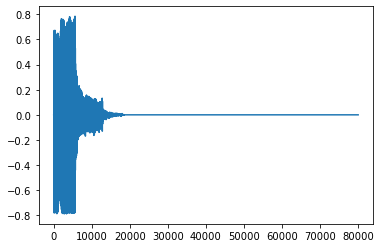

In [45]:
test_pd = filtered_pd.loc[filtered_pd['fold'] == 5]
row = test_pd.sample(1)
filename = row['filename'].item()
print(filename)
waveform = load_wav_16k_mono(filename)
print(f'Waveform values: {waveform}')
_ = plt.plot(waveform)

display.Audio(waveform, rate=16000)

In [46]:
# Run the model, check the output.
scores, embeddings, spectrogram = yamnet_model(waveform)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.argmax(class_scores)
infered_class = class_names[top_class]
top_score = class_scores[top_class]
print(f'[YAMNet] The main sound is: {infered_class} ({top_score})')

reloaded_results = reloaded_model(waveform)
your_top_class = tf.argmax(reloaded_results)
your_infered_class = my_classes[your_top_class]
class_probabilities = tf.nn.softmax(reloaded_results, axis=-1)
your_top_score = class_probabilities[your_top_class]
print(f'[Your model] The main sound is: {your_infered_class} ({your_top_score})')

[YAMNet] The main sound is: Silence (0.7139800190925598)
[Your model] The main sound is: cat (0.9846999645233154)


In [47]:
reloaded_results

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-2.5126128,  1.651871 ], dtype=float32)>

In [48]:
your_top_class

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [49]:
your_infered_class

'cat'

In [50]:
class_probabilities

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.0153    , 0.98469996], dtype=float32)>

## Next steps

You just created a model that can classify sounds from dogs or cats. With the same idea and proper data you could, for example, build a bird recognizer based on their singing.

Let us know what you come up with! Share your project with us on social media.
